# Using NeuralODEs in real life applications
-----
Tutorial by Tobias Thummerer | Last edit: November 08 2023

This workshop was held at the JuliaCon 2023 | July 25 2023 | MIT (Boston, USA)

Keywords: *#NeuralODE, #NeuralFMU, #SciML, #PeNODE, #HybridModeling*

## Workshop Video
[![YouTube Video of Workshop](https://img.youtube.com/vi/X_u0KlZizD4/0.jpg)](https://www.youtube.com/watch?v=X_u0KlZizD4)

## License

In [39]:
# Copyright (c) 2023 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMIFlux.jl/blob/main/LICENSE) file in the project root for details.

# This workshop was held at the JuliaCon2023 @ MIT (Boston)

## Introduction
NeuralODEs lead to amazing results in academic examples. But the expectations are often being disappointed as soon as one tries to adapt this concept for real life use cases. Bad convergence behavior, handling of discontinuities and/or instabilities are just some of the stumbling blocks that might pop up during the first steps. During the workshop, we want to show how to integrate real life industrial models in NeuralODEs using FMI and present sophisticated training strategies.

This tutorial can be used in two ways:
1. As a single script, showing how a NeuralFMU can be setup and trained. Results can be loaded from a precomputed hyperparameter optimization.
2. As a module (see sections *Optional: Organize as module*) together with the file `juliacon_2023_distributedhyperopt.jl` to perform your own distributed hyperparameter optimization.

This workshops divides into five sections:
1. Installing / Loading the Packages
2. Loading FMU & Data
3. NeuralFMU setup
4. Training the NeuralFMU
5. Results

## 1. Installing / Loading the Packages
Before we start modeling our NeuralODE, we load all required packages. If some packages are still missing, install them by typing `import Pkg; Pkg.add("[PKG-NAME]")`.

In [40]:
# Loading the required libraries
using FMI           # import FMUs into Julia 
using FMIFlux       # for NeuralFMUs
using FMIZoo        # a collection of demo models, including the VLDM
using FMIFlux.Flux  # Machine Learning in Julia

import JLD2         # data format for saving/loading parameters

import Random       # for fixing the random seed
using Plots         # plotting results

Beside the packages, we use another little script that includes some nice plotting functions specially for this workshop.

In [41]:
# a helper file with some predefined functions to make "things look nicer", but are not really relevant to the topic
include(joinpath(@__DIR__, "juliacon_2023_helpers.jl"));

Because notebooks can't handle progress bars, we disable *progress bar printing* - but feel free to enable it if you are using the code outside of a jupyter notebook. The progress bar gives further helpful information, like the estimated remaining computation time for simulation and training.

In [42]:
# disable progress bars in jupyter notebook
showProgress=false;

## 2. Loading FMU & Data
Before starting with hybrid modeling, we load in the used training data and our FMU of the VLDM. We simulate the FMU, plot the results and compare them to data. 

### 2.1 Loading measurement data
We start by loading in the data (training and validation) used in this tutorial from *FMIZoo.jl* - a container library for different system model FMUs and corresponding data.

**Note:** There where two measurements done, so data is a mean value with some deviation around (not an exact line).

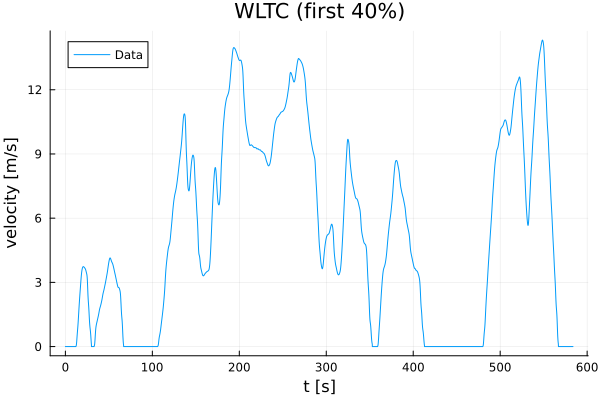

In [43]:
# FMIZoo.jl supports different data sampling rates (by interpolation), sample length for data is 0.1s
dt = 0.1 

# load data (training) from FMIZoo.jl
data = VLDM(:train, dt=dt) 

# plot the velocity consumption (training data)
plot(data.speed_t,              # the time points the speed was captures (from data)
     data.speed_val;            # the speeds at the considered time points (from data)
     ribbon=data.speed_dev,     # a `ribbon` for the speed deviation - so the `uncertainty` because we made two measurements - but don't expect too much to see (very little uncertainty)
     fillalpha=0.3,             # alpha value for the ribbon
     label="Data",              # the plot label
     title="WLTC (first 40%)",  # plot title
     xlabel="t [s]",            # plot x-label
     ylabel="velocity [m/s]")   # plot y-label

Further, we load validation data and have a look on it, too.

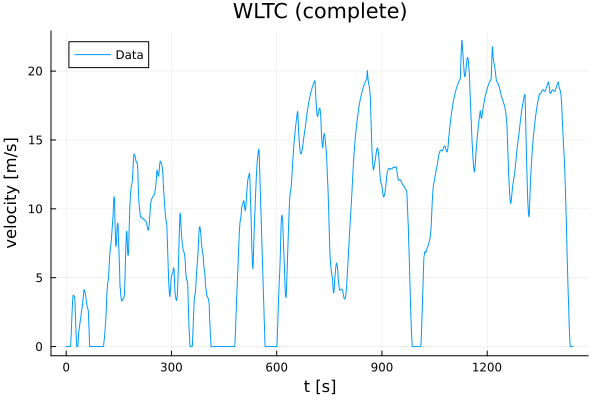

In [44]:
# load data (validation) from FMIZoo.jl
data_validation = VLDM(:validate, dt=dt)

# plot the velocity consumption (validation data)
plot(data_validation.speed_t, data_validation.speed_val; label="Data", ribbon=data_validation.speed_dev, fillalpha=0.3, title="WLTC (complete)", xlabel="t [s]", ylabel="velocity [m/s]")

Let's extract a simulation starting time `tStart` and stopping time `tStop` from data - so we simulate as far as data is available. `tSave` are the points in time we want our ODE solution beeing saved later.

In [45]:
# start (`tStart`) and stop time (`tStop`) for simulation, saving time points for ODE solver (`tSave`)
tStart = data.consumption_t[1]
tStop = data.consumption_t[end]
tSave = data.consumption_t

5838-element Vector{Float64}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   ⋮
 582.9
 583.0
 583.1
 583.2
 583.3
 583.4
 583.5
 583.6
 583.7

So you can see time points are sampled with `dt=0.1` as specified and the cycle ranges from $0.0s$ to $583.7s$.

Next is to get a value for the start state `x0`, so the initial state to solve the FMU and NeuralFMU.

In [46]:
# get start state vector from data (FMIZoo)
x0 = FMIZoo.getStateVector(data,    # the data container
                           tStart)  # the point in time where we want the state

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In this special case, it's all zero, but this is not the default over different system!

Further, we can check for the loaded FMU parameters, that are paths to the used characterisitc maps used in the model.

In [47]:
# have a look on the FMU parameters (these are the file paths to the characteristic maps, remaining parameters are set to default by the FMU)
display(data.params)

Dict{String, Any} with 3 entries:
  "peFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…
  "edFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…
  "dcFileName" => "C:\\Users\\thummeto\\Documents\\FMIZoo.jl\\src\\..\\data\\VL…

After that, we load the FMU and have a look on its model meta data.

In [48]:
# load our FMU of the VLDM (we take it from the FMIZoo.jl, exported with Dymola 2020x)
fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME) 

# let's have a look on the model meta data
fmiInfo(fmu)

#################### Begin information for FMU ####################
	Model name:			Longitudinaldynamic.LongitudinaldynamicmodelContinuous
	FMI-Version:			2.0
	GUID:				{669889ab-7ab7-4fac-be92-96b6cd0b86a6}
	Generation tool:		Dymola Version 2020x (64-bit), 2019-10-10
	Generation time:		2022-07-22T09:32:50Z
	Var. naming conv.:		structured
	Event indicators:		28
	Inputs:				0
	Outputs:			0
	States:				6
		33554432 ["driver.accelerationPedalController.PI.x"]
		33554433 ["driver.brakePedalController.PI.x"]
		33554434 ["drivingCycle.s"]
		33554435 ["dynamics.accelerationCalculation.integrator.y"]
		33554436 ["dynamics.accelerationCalculation.limiter.u", "dynamics.accelerationCalculation.limIntegrator.y", "dynamics.accelerationCalculation.limiter.simplifiedExpr"]
		33554437 ["result.integrator.y"]
	Supports Co-Simulation:		true
		Model identifier:	Longitudinaldynamic_LongitudinaldynamicmodelContinuous
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	

One can find many useful things, like the number of states (6), inputs (0) and outputs (0), their names and information about supported features. 

### 2.2 Simulating the FMU
Simulating is as easy as calling `fmiSimulate`. Note, that we are putting in the paramter dictionary `data.params` from above. This FMU has many events, these are detected and handled automatically by *FMI.jl*.

In [49]:
# let's run a simulation from `tStart` to `tStop`, use the parameters we just viewed for the simulation run
resultFMU = fmiSimulate(fmu,                        # the loaded FMU of the VLDM 
                        (tStart, tStop);            # the simulation time range
                        parameters=data.params,     # the parameters for the VLDM
                        showProgress=showProgress,  # show (or don't) the progres bar
                        recordValues=:derivatives,  # record all state derivatives
                        saveat=tSave)               # save solution points at `tSave`
display(resultFMU)

Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 351569
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂x: 0
	∂y_∂u: 0
	∂e_∂x: 0
	∂e_∂u: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
	∂e_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 702563
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 5838
	Steps completed: 58453
States [5838]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	0.1	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 14.260000000955804]
	0.2	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 28.52000000095581]
	0.3	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 42.78000000095581]
	0.4	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 57.0400000009

This way, you can see interessting metadata on the solution process, like the number of evaluations of the ODE-function, sensitivity or callback evaluations. 

We can use the `plot` command to plot simulation results from FMUs, too!

┌ Info: fmiPlot(...): Number of time events (58370) exceeding 100, disabling automatic plotting of time events (can be forced with keyword `timeEvents=true`).
└ @ FMI C:\Users\thummeto\Documents\FMI.jl\src\extensions\Plots.jl:104


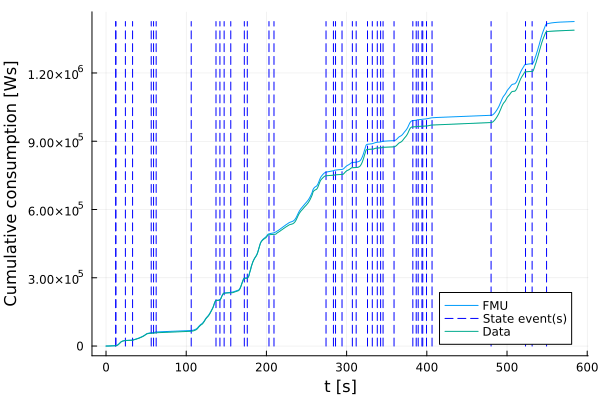

In [50]:
# Plot the simulation results
fig = plot(resultFMU;                               # the simulation result from above 
           values=false,                            # don't plot values (:derivatives)
           stateIndices=6:6,                        # only plot states 6 to 6 -> so state 6 ;-)
           ylabel="Cumulative consumption [Ws]",    # set the title for the y-label
           label="FMU")                             # title the plot line 

# further plot the (measurement) data values `consumption_val` and deviation between measurements `consumption_dev`
plot!(fig, data.cumconsumption_t, data.cumconsumption_val; label="Data", ribbon=data.cumconsumption_dev, fillalpha=0.3)

The simulation result we already know from the introduction!

## 3. NeuralFMU setup

![NeuralFMU](https://github.com/thummeto/FMIFlux.jl/blob/main/docs/src/examples/img/juliacon_2023/neuralfmu_topology.png?raw=true)

Equipped with data and a simulation model, we can setup the NeuralFMU as introduced in the workshop.


### 3.1 Pre- and Post-Processing
We gather the three derivative values from the last simulation run, to have values for initialization of the pre- and post-processing layers.

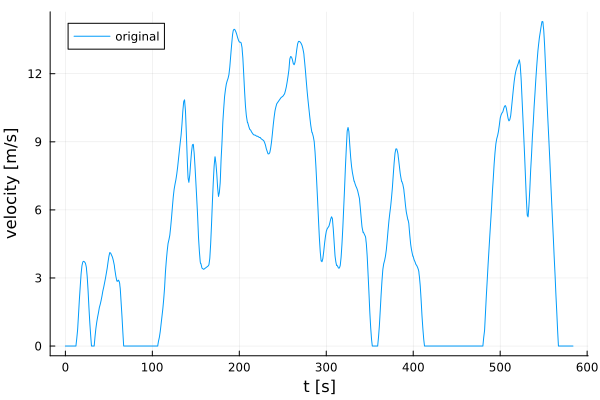

In [51]:
# variable we want to manipulate - why we are picking exactly these three is shown a few lines later ;-)
manipulatedDerVars = ["der(dynamics.accelerationCalculation.integrator.y)",
                      "der(dynamics.accelerationCalculation.limIntegrator.y)",
                      "der(result.integrator.y)"]
manipulatedDerVals = fmiGetSolutionValue(resultFMU, manipulatedDerVars)

# what happens without propper transformation between FMU- and ANN-domain?
plot(resultFMU.values.t, manipulatedDerVals[1,:][1]; label="original", xlabel="t [s]", ylabel="velocity [m/s]")

But what happens if we put the velocity into the hyperbolic tangens function?

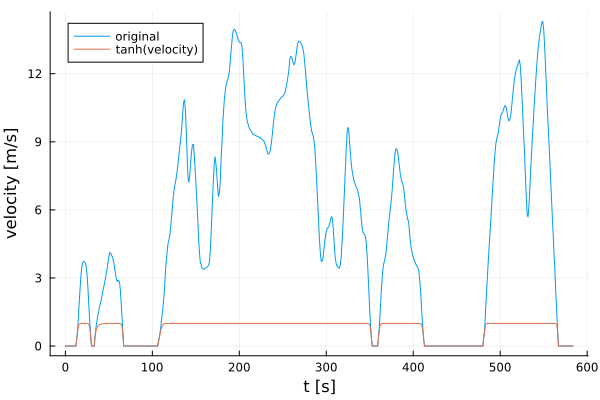

In [52]:
plot!(resultFMU.values.t, tanh.(manipulatedDerVals[1,:][1]); label="tanh(velocity)")

It gets saturated drastically! That's why we need shift- and scale layers for online pre- and post-processing!

We introduce the `ShiftScale`-layer for pre-processing our data.

In [53]:
# pre- and post-processing
preProcess = ShiftScale(manipulatedDerVals);    # we put in the derivatives recorded above, FMIFlux shift and scales so we have a data mean of 0 and a standard deivation of 1 (other activation functions / ranges are possible!)

How does the velocity look after pushing it through the `ShiftScale`-layer?

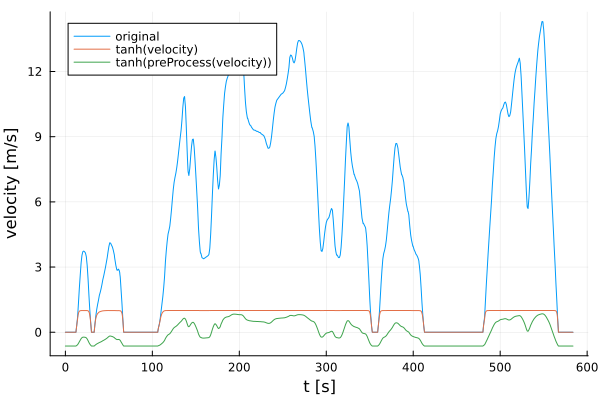

In [54]:
testVals = collect(tanh(preProcess(collect(val[t] for val in manipulatedDerVals))[1]) for t in 1:length(resultFMU.values.t))
plot!(resultFMU.values.t, 
      testVals; 
      label="tanh(preProcess(velocity))")

You can clearly see, that after pre-processing, the trajectory (green) still mirrors the dynamical behaviour of the original system (blue), while the not pre-processed option (orange) just saturates values. 

In [55]:
# we add some additional "buffer" - this is not necessary but helps to preserve peakes
preProcess.scale[:] *= 0.25;    

# initialize the postPrcess as inverse of the preProcess, but only take indices 2 and 3 (we don't need 1, the vehcile velocity)
postProcess = ScaleShift(preProcess; indices=2:3);

### 3.2 Building the NeuralFMU

To make this more usable, we put the entire NeuralFMU building process (including the pre- and post-processing we had a detailed look on) into a dedicated function `build_FMU`.

In [56]:
# function that builds the considered NeuralFMU on basis of a given FMU (FMI-Version 2.0) `f`
function build_NFMU(f::FMU2)
    
    # pre- and post-processing
    preProcess = ShiftScale(manipulatedDerVals)         # we put in the derivatives recorded above, FMIFlux shift and scales so we have a data mean of 0 and a standard deivation of 1
    preProcess.scale[:] *= 0.25                         # add some additional "buffer"
    postProcess = ScaleShift(preProcess; indices=2:3)   # initialize the postPrcess as inverse of the preProcess, but only take indices 2 and 3 (we don't need 1, the vehcile velocity)

    # cache
    cache = CacheLayer()                        # allocate a cache layer
    cacheRetrieve = CacheRetrieveLayer(cache)   # allocate a cache retrieve layer, link it to the cache layer

    # we have two signals (acceleration, consumption) and two sources (ANN, FMU), so four gates:
    # (1) acceleration from FMU (gate=1.0 | open)
    # (2) consumption  from FMU (gate=1.0 | open)
    # (3) acceleration from ANN (gate=0.0 | closed)
    # (4) consumption  from ANN (gate=0.0 | closed)
    # the acelerations [1,3] and consumptions [2,4] are paired
    gates = ScaleSum([1.0, 1.0, 0.0, 0.0], [[1,3], [2,4]]) # gates with sum

    # setup the NeuralFMU topology
    model = Chain(x -> f(; x=x, dx_refs=:all),        # take `x`, put it into the FMU, retrieve all derivatives `dx`
                  dx -> cache(dx),                    # cache `dx`
                  dx -> dx[4:6],                      # forward only dx[4, 5, 6]
                  preProcess,                         # pre-process `dx`
                  Dense(3, 32, tanh),                 # Dense Layer 3 -> 32 with `tanh` activation
                  Dense(32, 2, tanh),                 # Dense Layer 32 -> 2 with `tanh` activation 
                  postProcess,                        # post process `dx`
                  dx -> cacheRetrieve(5:6, dx),       # dynamics FMU | dynamics ANN
                  gates,                              # compute resulting dx from ANN + FMU
                  dx -> cacheRetrieve(1:4, dx))       # stack together: dx[1,2,3,4] from cache + dx[5,6] from gates

    # new NeuralFMU 
    neuralFMU = ME_NeuralFMU(f,                 # the FMU used in the NeuralFMU 
                             model,             # the model we specified above 
                             (tStart, tStop),   # a default start ad stop time for solving the NeuralFMU
                             saveat=tSave)      # the time points to save the solution at
    neuralFMU.modifiedState = false             # speed optimization (NeuralFMU state equals FMU state)
    
    return neuralFMU 
end

build_NFMU (generic function with 1 method)

Let's test the NeuralFMU: First, load the FMU und built a NeuralFMU from it.

In [57]:
# build NeuralFMU
neuralFMU = build_NFMU(fmu);

Next, do a simulation for a given start state `x0` from *FMIZoo.jl*.

In [58]:
# simulate and plot the (uninitialized) NeuralFMU
resultNFMU = neuralFMU(x0,                          # the start state to solve the ODE
                       (tStart, tStop);             # the simulation range
                       parameters=data.params,      # the parameters for the VLDM
                       showProgress=showProgress,   # show progress (or not)
                       saveat=tSave)                # the time points to save the solution at

display(resultNFMU)     

Model name:
	Longitudinaldynamic.LongitudinaldynamicmodelContinuous
Success:
	true
f(x)-Evaluations:
	In-place: 351551
	Out-of-place: 0
Jacobian-Evaluations:
	∂ẋ_∂x: 0
	∂ẋ_∂u: 0
	∂y_∂x: 0
	∂y_∂u: 0
	∂e_∂x: 0
	∂e_∂u: 0
Gradient-Evaluations:
	∂ẋ_∂t: 0
	∂y_∂t: 0
	∂e_∂t: 0
Callback-Evaluations:
	Condition (event-indicators): 702407
	Time-Choice (event-instances): 58371
	Affect (event-handling): 58409
	Save values: 0
	Steps completed: 58440
States [5838]:
	0.0	[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	0.1	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 14.260000000955804]
	0.2	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 28.52000000095581]
	0.3	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 42.78000000095581]
	0.4	[-1.0313822985067192e-12, -1.5470734477600789e-12, 0.0, 7.219676089547036e-12, -1.0224379404543445e-5, 57.0400000009558

As for the FMU, we can display the NeuralFMU simulation result and check some statisitics.

Now, let's have a look on the cumulative consumption plot ...

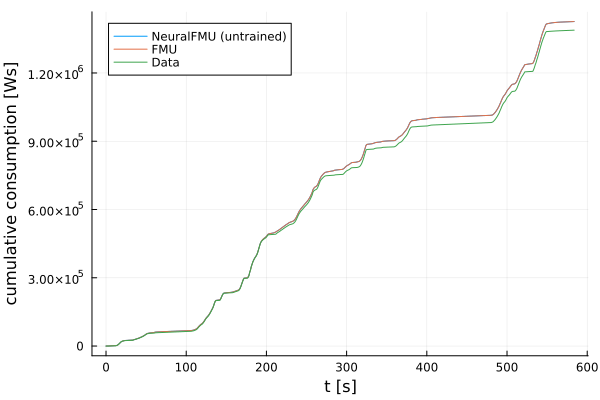

In [59]:
# plot the NeuralFMU, original FMU and data (cumulative consumption)
fig = plot(resultNFMU; stateIndices=6:6, stateEvents=false, timeEvents=false, label="NeuralFMU (untrained)", ylabel="cumulative consumption [Ws]")
plot!(fig, resultFMU; stateIndices=6:6, values=false, stateEvents=false, timeEvents=false, label="FMU")
plot!(fig, data.cumconsumption_t, data.cumconsumption_val, label="Data")

As you can see, the FMU und NeuralFMU result looks identically - and this is what we expect for a fully open FMU gate and a fully closed ANN gate!

Finally, unload the FMU and invalidate the NeuralFMU.

In [60]:
# unload FMU / invalidate NeuralFMU
fmiUnload(fmu)
neuralFMU = nothing

## 4. Training the NeuralFMU

An untrained NeuralFMU is not that impressive - so let's train it a bit. 

We start by defining a time sequence (the time points of data measurements) and the cumulative consumption values we want to train for.

In [61]:
# prepare training data 
train_t = data.consumption_t 

# data is as "array of arrays" required (often we have multidimensional data)
train_data = collect([d] for d in data.cumconsumption_val)

5838-element Vector{Vector{Float64}}:
 [0.0]
 [-0.41296068176650935]
 [0.26787411983582043]
 [0.7202168791949798]
 [1.0714482470335085]
 [1.390037422822217]
 [2.1200151652794643]
 [2.5196535613914306]
 [2.656369007464336]
 [2.993187294279602]
 ⋮
 [1.3879825294049252e6]
 [1.3879980607748663e6]
 [1.3880134565080018e6]
 [1.3880287579379592e6]
 [1.388044098663902e6]
 [1.388059371012591e6]
 [1.388074504338062e6]
 [1.3880896849414955e6]
 [1.3881049434185931e6]

The data sequence is too long to train on it all at once - so we **need to batch** our data.

First, we introduce some hyperparameters. Training success always depends on a good choice of hyperparameters, we use the following hyperparameters in this workshop:
- `BATCHDUR` the duration of a single batch element (length) in seconds.
- `TRAINDUR` specifies the training duration (meassured on data) in seconds.
- `ETA` the update rate $\eta$ of the *Adam* optimizer.
- `BETA1` the first momentum coefficient $\beta_1$ of the *Adam* optimizer.
- `BETA2` the second momentum coefficient $\beta_2$ of the *Adam* optimizer. 
- `LASTWEIGHT` a weighting factor between the last solution point and all remaining solution points.
- `SCHEDULER` an identifier for the batch scheduler, can be `:Sequential`, `:Random` or `:LossAccumulation`.
- `LOSS` an identifier for the loss function to use, `:MAE` or `:MSE`.

Next, the loss function is defined. The loss is computed on basis of a given `solution` and `data`. Dependent on the hyperparameter `LOSS`, either `:MAE` or `:MSE` is used to compute the loss. The hyperparameter `LASTWEIGHT` determines how much the last solution point is weight against the remaining solution points. For example a value of $0.3$ determines that the last point of the solution contributes $30\%$ to the loss, whereas all remaining solution points contribute $70\%$ in total.

In [62]:
function _lossFct(solution::FMU2Solution, data::VLDM_Data, LOSS::Symbol, LASTWEIGHT::Real=1.0/length(data.consumption_t) )

    # determine the start/end indices `ts` and `te` in the data array (sampled with 10Hz)
    ts = dataIndexForTime(solution.states.t[1])
    te = dataIndexForTime(solution.states.t[end])
    
    # retrieve the data from NeuralODE ("where we are") and data from measurements ("where we want to be") and an allowed deviation ("we are unsure about")
    nfmu_cumconsumption = fmiGetSolutionState(solution, 6; isIndex=true)
    cumconsumption = data.cumconsumption_val[ts:te]
    cumconsumption_dev = data.cumconsumption_dev[ts:te]

    Δcumconsumption = 0.0
    if LOSS == :MAE
        Δcumconsumption = FMIFlux.Losses.mae_last_element_rel_dev(nfmu_cumconsumption,  # NeuralFMU 
                                                                  cumconsumption,       # data target
                                                                  cumconsumption_dev,   # data uncertainty
                                                                  LASTWEIGHT)           # how much do we scale the last point compared to the remaing ones?
    elseif LOSS == :MSE
        Δcumconsumption = FMIFlux.Losses.mse_last_element_rel_dev(nfmu_cumconsumption, 
                                                                  cumconsumption, 
                                                                  cumconsumption_dev, 
                                                                  LASTWEIGHT)
    else
        @assert false, "Unknown LOSS: `$(LOSS)`"
    end
    
    return Δcumconsumption 
end

_lossFct (generic function with 2 methods)

Finally, the function `train!` is defined, that triggers a new training run for a given set of hyperparameters `hyper_params`, a training ressource `ressource` and the current training index `ind`.

In [63]:
# ressource = training time horizon (duration of data seen)
function train!(hyper_params, ressource, ind)

    # make the runs determinisitic by fixing the random seed
    Random.seed!(1234)

    # training duration (in seconds) equals the given ressource
    TRAINDUR = ressource

    # unpack the hyperparemters
    ETA, BETA1, BETA2, BATCHDUR, LASTWEIGHT, SCHEDULER, LOSS = hyper_params

    # compute the number of training steps TRAINDUR / BATCHDUR, but do at least one step
    steps = max(round(Int, TRAINDUR/BATCHDUR), 1) 

    # print a bit of info
    @info "--------------\nStarting run $(ind) with parameters: $(hyper_params) and ressource $(ressource) doing $(steps) step(s).\n--------------------"

    # load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2020x)
    fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME) 

    # built the NeuralFMU on basis of the loaded FMU `fmu`
    neuralFMU = build_NFMU(fmu)

    # a more efficient execution mode
    fmiSingleInstanceMode(fmu, true)
    
    # batch the data (time, targets), train only on model output index 6, plot batch elements
    batch = batchDataSolution(neuralFMU,                            # our NeuralFMU model
                              t -> FMIZoo.getStateVector(data, t),  # a function returning a start state for a given time point `t`, to determine start states for batch elements
                              train_t,                              # data time points
                              train_data;                           # data cumulative consumption 
                              batchDuration=BATCHDUR,               # duration of one batch element
                              indicesModel=6:6,                     # model indices to train on (6 equals the state `cumulative consumption`)
                              plot=false,                           # don't show intermediate plots (try this outside of Jupyter)
                              parameters=data.params,               # use the parameters (map file paths) from *FMIZoo.jl*
                              showProgress=showProgress)            # show or don't show progess bar, as specified at the very beginning

    # limit the maximum number of solver steps to 1000 * BATCHDUR (longer batch elements get more steps)
    # this allows the NeuralFMU to do 10x more steps (average) than the original FMU, but more should not be tolerated (to stiff system)
    solverKwargsTrain = Dict{Symbol, Any}(:maxiters => round(Int, 1000*BATCHDUR)) 
    
    # a smaller dispatch for our custom loss function, only taking the solution object
    lossFct = (solution::FMU2Solution) -> _lossFct(solution, data, LOSS, LASTWEIGHT)

    # selecting a scheduler for training
    scheduler = nothing
    if SCHEDULER == :Random
        # a scheduler that picks a random batch element
        scheduler = RandomScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :Sequential
        # a scheduler that picks one batch element after another (in chronological order)
        scheduler = SequentialScheduler(neuralFMU, batch; applyStep=1, plotStep=0)
    elseif SCHEDULER == :LossAccumulation
        # a scheduler that picks the element with largest accumulated loss:
        # - after every training step, the accumulated loss for every batch element is increased by the current loss value 
        # - when picking a batch element, the accumulated loss is reset to zero
        # - this promotes selecting elements with larger losses more often, but also prevents starving of elements with small losses
        scheduler = LossAccumulationScheduler(neuralFMU, batch, lossFct; applyStep=1, plotStep=0, updateStep=1)
    else 
        @error "Unknown SCHEDULER: ´$(SCHEDULER)´."
        return nothing
    end

    # loss for training, do a simulation run on a batch element taken from the scheduler
    loss = p -> FMIFlux.Losses.loss(neuralFMU,                          # the NeuralFMU to simulate
                                    batch;                              # the batch to take an element from
                                    p=p,                                # the NeuralFMU training parameters (given as input)
                                    parameters=data.params,             # the FMU paraemters
                                    lossFct=lossFct,                    # our custom loss function
                                    batchIndex=scheduler.elementIndex,  # the index of the batch element to take, determined by the choosen scheduler
                                    logLoss=true,                       # log losses after every evaluation
                                    showProgress=showProgress,          # show progress bar (or don't)
                                    solverKwargsTrain...)               # the solver kwargs defined above

    # gather the parameters from the NeuralFMU
    params = FMIFlux.params(neuralFMU)

    # initialize the scheduler, keywords are passed to the NeuralFMU
    initialize!(scheduler; parameters=data.params, p=params[1], showProgress=showProgress)
    
    # initialize Adam optimizer with our hyperparameters
    optim = Adam(ETA, (BETA1, BETA2))
   
    # the actual training
    FMIFlux.train!(loss,                            # the loss function for training
                   params,                          # the parameters to train
                   Iterators.repeated((), steps),   # an iterator repeating `steps` times
                   optim;                           # the optimizer to train
                   gradient=:ForwardDiff,           # currently, only ForwarDiff leads to good results for multi-event systems
                   chunk_size=32,                   # ForwardDiff chunk_size (=number of parameter estimations per run)
                   cb=() -> update!(scheduler),     # update the scheduler after every step 
                   proceed_on_assert=true)          # proceed, even if assertions are thrown, with the next step
    
    # the default execution mode
    fmiSingleInstanceMode(fmu, false)

    # save our result parameters
    fmiSaveParameters(neuralFMU, joinpath(@__DIR__, "params", "$(ind).jld2"))
    
    # simulate the NeuralFMU on a validation trajectory
    resultNFMU = neuralFMU(x0, (data_validation.consumption_t[1], data_validation.consumption_t[end]); parameters=data_validation.params, showProgress=showProgress, maxiters=1e7, saveat=data_validation.consumption_t)

    # determine loss on validation data (if the simulation was successfull)
    validation_loss = nothing 
    if resultNFMU.success
        # compute the loss on VALIDATION data 
        validation_loss = _lossFct(resultNFMU,      # the NeuralFMU
                                  data_validation,  # the validation data set 
                                  :MSE)             # use MSE 
    end        

    # unload FMU
    fmiUnload(fmu)

    # return the loss (or `nothing` if no loss can be determined)
    return validation_loss
end

train! (generic function with 1 method)

Let's check if the train function is working for a given set of hyperparameters.

In [64]:
# check if the train function is working for a set of given (random) hyperparameters
#     ([  ETA, BETA1,  BETA2, BATCHDUR, LASTWEIGHT, SCHEDULER, LOSS], RESSOURCE, INDEX)
train!([0.0001,  0.9,  0.999,      4.0,        0.7,   :Random, :MSE],      8.0,     1) 

┌ Info: --------------
│ Starting run 1 with parameters: Any[0.0001, 0.9, 0.999, 4.0, 0.7, :Random, :MSE] and ressource 8.0 doing 2 step(s).
│ --------------------
└ @ Main c:\Users\thummeto\Documents\FMIFlux.jl\examples\src\juliacon_2023.ipynb:17


# 5. Results 
After training with a set of good hyperparameters, results can be loaded (one set is already preparred if you skipped the optimization).

In [ ]:
# load our FMU (we take one from the FMIZoo.jl, exported with Dymola 2020x)
fmu = fmiLoad("VLDM", "Dymola", "2020x"; type=:ME)

# build NeuralFMU
neuralFMU = build_NFMU(fmu)

# load parameters from hyperparameter optimization
fmiLoadParameters(neuralFMU, joinpath(@__DIR__, "juliacon_2023.jld2"))

# simulate and plot the NeuralFMU
resultNFMU =   neuralFMU(x0,  (tStart, tStop); parameters=data.params, showProgress=showProgress, saveat=tSave) 
resultFMU  = fmiSimulate(fmu, (tStart, tStop); parameters=data.params, showProgress=showProgress, saveat=tSave) 

# plot the NeuralFMU, original FMU and data (cumulative consumption)
fig = plot(resultNFMU; stateIndices=6:6, stateEvents=false, timeEvents=false, label="NeuralFMU", ylabel="cumulative consumption [m/s]")
plot!(fig, resultFMU; stateIndices=6:6, values=false, stateEvents=false, timeEvents=false, label="FMU")
plot!(fig, data.cumconsumption_t, data.cumconsumption_val, label="Data")

We also have a ready-to-use function that calculates different errors and plots them.

In [ ]:
plotCumulativeConsumption(resultNFMU, resultFMU, data; filename=joinpath(@__DIR__, "comparision_train_100.png"))

Because the deviation is small, let's check the last 10% of WLTC focussed, so from 90% to 100%.

In [ ]:
plotCumulativeConsumption(resultNFMU, resultFMU, data; range=(0.9, 1.0), filename=joinpath(@__DIR__, "comparision_train_10.png"))

Finally, we should check the results on validation data: The full WLTC cycle.

In [ ]:
# get start and stop for the validation cycle (full WLTC)
tStart_validation = data_validation.cumconsumption_t[1]
tStop_validation = data_validation.cumconsumption_t[end]
tSave_validation = data_validation.cumconsumption_t

# simulate the NeuralFMU on validation data
resultNFMU =   neuralFMU(x0,  (tStart_validation, tStop_validation); parameters=data_validation.params, showProgress=showProgress, saveat=tSave_validation) 
resultFMU  = fmiSimulate(fmu, (tStart_validation, tStop_validation); parameters=data_validation.params, showProgress=showProgress, saveat=tSave_validation) 

plotCumulativeConsumption(resultNFMU, resultFMU, data_validation; filename=joinpath(@__DIR__, "comparision_validation_100.png"))

... and the last 10% ...

In [ ]:
plotCumulativeConsumption(resultNFMU, resultFMU, data_validation; range=(0.9, 1.0), filename=joinpath(@__DIR__, "comparision_validation_10.png"))

Check out the **error values** in the legend: This is an enhancement of factor x326 on MSE, x22 on MAE and x11 on MAX error, wow!

Finally some plotting "sugar": A plot showing for which locations in derivative-space the model enhanced the cumulative consumption prediction the most:

In [ ]:
plotEnhancements(neuralFMU, fmu, data; filename=joinpath(@__DIR__, "NFMU_consumption.gif"))

After we finished, let's finally unload the FMU and invalidate the NeuralFMU.

In [ ]:
# unload FMU / invalidate NeuralFMU
fmiUnload(fmu)
neuralFMU = nothing

**But:** We did look on some results, but did not talk about where the used hyperparameters came from ...

They come from hyperparameter optimization - and this step is necessary for NeuralODEs too! 

# Optional: Organize as module
If you want, you can place all code inside of a module named `NODE_Training`, this simplifies hyper parameter optimization (if you want to do one).

In [ ]:
# for hyper parameter optimization, place the code in a `module`
# uncomment the following three lines and place them at the very beginning
 
#module NODE_Training 
#using DistributedHyperOpt
#using DistributedHyperOpt.Distributed 

# ... and uncomment the following line
#end # NODE_Training 